In [1]:
!pip install evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.5 MB/s eta 0:00:00


In [2]:
!pip uninstall -y transformers accelerate evaluate rouge_score
!pip install transformers accelerate evaluate rouge_score

Found existing installation: transformers 4.44.0
Uninstalling transformers-4.44.0:
  Successfully uninstalled transformers-4.44.0
Found existing installation: accelerate 0.33.0
Uninstalling accelerate-0.33.0:
  Successfully uninstalled accelerate-0.33.0
Found existing installation: evaluate 0.4.3
Uninstalling evaluate-0.4.3:
  Successfully uninstalled evaluate-0.4.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 71.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 19.5 MB/s eta 0:00:00
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b72a18748d19fffb2dd9c6f923582456c0712f854ad84c4f3dde257ae1c04196
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a

In [3]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.17.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.17.0 which is incompatible.
tf-keras 2.

In [4]:
import os
import pandas as pd
import re
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from datasets import Dataset, DatasetDict
import evaluate
import torch

2024-09-24 16:44:54.548026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 16:44:54.572122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 16:44:54.578893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Ensure you are using the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
import evaluate
sacrebleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load('rouge')

In [7]:
import re
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

In [8]:
# Function to move tensors to the correct device
def move_to_device(batch, device):
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    return batch

In [63]:
def convert_csv_to_txt(csv_path, output_path, lowercase=False, clean=False):
    with open(csv_path, 'r', encoding='utf-8') as csv_file, open(output_path, 'w', encoding='utf-8') as txt_file:
        csv_reader = csv.reader(csv_file, delimiter=',')  # Use the correct delimiter (comma or tab)
        
        for row in csv_reader:
            # Check if the row has at least two columns (Question and Answer)
            if len(row) >= 2:
                question = row[0].strip() if row[0] else ""
                answer = row[1].strip() if row[1] else ""

                # Apply lowercase and cleaning options
                if lowercase:
                    question = question.lower()
                    answer = answer.lower()
                if clean:
                    question = clean_text(question)
                    answer = clean_text(answer)

                # Remove the "Answer:" prefix from the answer
                if answer.lower().startswith("answer:"):
                    answer = answer[len("answer:"):].strip()

                # Write formatted Question and Answer to the output text file
                if question and answer:
                    txt_file.write(f"Question: {question}\nAnswer: {answer}\n\n")

In [64]:
dataset_path ='/kaggle/input/qa-dataset'

In [113]:
# File paths to the two CSV files
csv_file_1 = '/kaggle/input/qa-dataset/aiml_qa_train_1.csv'
csv_file_2 = '/kaggle/input/qa-dataset/train_1.csv'

# Output file path for the concatenated CSV
concatenated_csv = '/kaggle/working/concatenated_training.csv'

# Open the output file in write mode
with open(concatenated_csv, 'w', encoding='utf-8') as fout:  # Output file with UTF-8
    # Open and read the first CSV with ISO-8859-1 encoding
    with open(csv_file_1, 'r', encoding='ISO-8859-1') as f1:
        fout.write(f1.read() + '\n')  # Add newline to separate rows
    
    # Open and read the second CSV with ISO-8859-1 encoding
    with open(csv_file_2, 'r', encoding='ISO-8859-1') as f2:
        fout.write(f2.read() + '\n')  # Add newline to separate rows

In [115]:
# Path to your CSV file
csv_path = '/kaggle/working/concatenated_training.csv'

# Open the CSV file and print the header
with open(csv_path, 'r', encoding='windows-1252') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)
    print("CSV Header:", header)


CSV Header: ['Question :What is the difference between concatenation vs. summation of two tensors?', 'Answer :Concatenation combines two tensors by adding them together along a specified dimension. Summation adds the elements of two tensors together element-wise.']


In [116]:
# Convert CSV files to text format 
convert_csv_to_txt('/kaggle/working/concatenated_training.csv', 'train.txt', lowercase=True, clean=True)
convert_csv_to_txt(dataset_path + '/dev_1.csv', 'dev.txt', lowercase=True, clean=True)

In [117]:
convert_csv_to_txt(dataset_path + '/test_1.csv', 'test.txt', lowercase=True, clean=True)

In [118]:
train_txt_file = '/kaggle/working/train.txt'
dev_txt_file = '/kaggle/working/dev.txt'
test_txt_file = '/kaggle/working/test.txt'

In [119]:
def load_txt_data(file_path):
    questions = []
    answers = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read().split("\n\n")  
        for entry in content:
            if "Question:" in entry and "Answer:" in entry:
                question = re.search(r"Question:(.+)", entry)
                answer = re.search(r"Answer:(.+)", entry)
                if question and answer:
                    questions.append(question.group(1).strip())
                    answers.append(answer.group(1).strip())
    return questions, answers

In [120]:
# Load datasets
train_questions, train_answers = load_txt_data('/kaggle/working/train.txt')
val_questions, val_answers = load_txt_data('/kaggle/working/dev.txt')
test_questions, test_answers = load_txt_data('/kaggle/working/test.txt')

# Convert to a format compatible with HuggingFace Dataset
train_data = {
    'question': train_questions,
    'answer': train_answers
}

val_data = {
    'question': val_questions,
    'answer': val_answers
}

test_data = {
    'question': test_questions,
    'answer': test_answers
}

In [121]:
print("Number of train questions:", len(train_questions))
print("Number of train answers:", len(train_answers))
print("Number of val questions:", len(val_questions))
print("Number of val answers:", len(val_answers))
print("Number of val questions:", len(test_questions))
print("Number of val answers:", len(test_answers))

Number of train questions: 2626
Number of train answers: 2626
Number of val questions: 248
Number of val answers: 248
Number of val questions: 249
Number of val answers: 249


In [122]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [123]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2626, 2)
(249, 2)
(248, 2)


In [124]:
# Convert DataFrames to Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

In [125]:
len(train_dataset)

2626

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


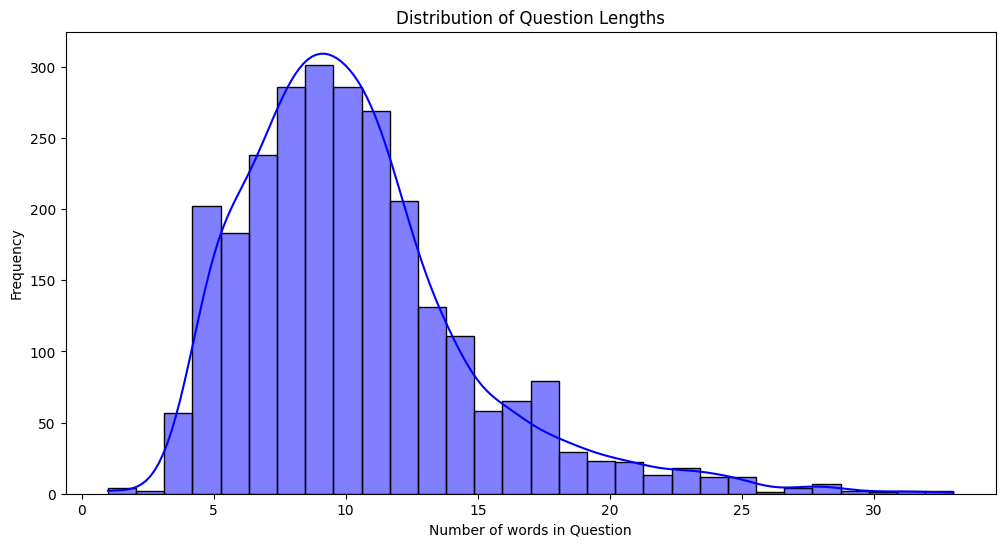

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


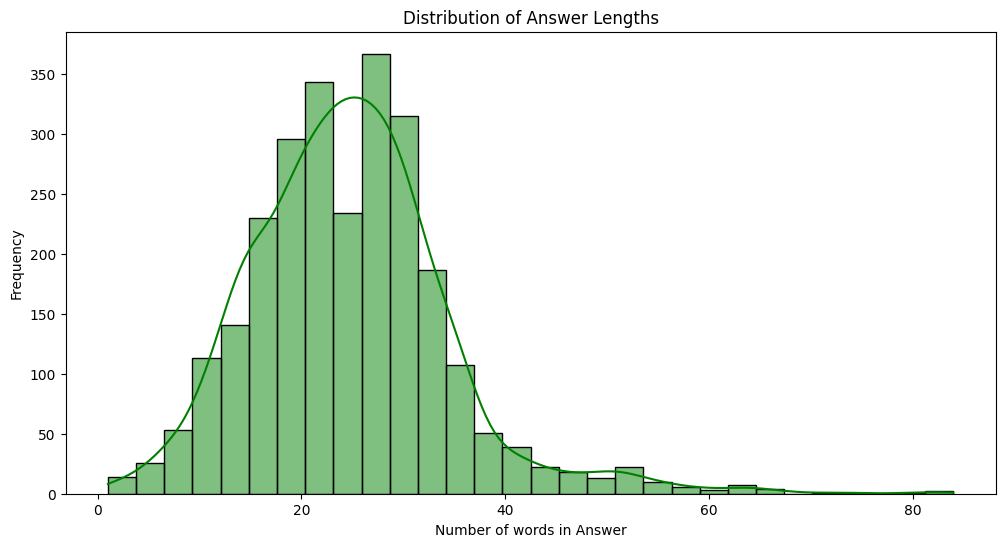

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

# Length of questions and answers (number of words)
train_df['question_length'] = train_df['question'].apply(lambda x: len(x.split()))
train_df['answer_length'] = train_df['answer'].apply(lambda x: len(x.split()))

# Plot the distribution of question lengths
plt.figure(figsize=(12, 6))
sns.histplot(train_df['question_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of words in Question')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of answer lengths
plt.figure(figsize=(12, 6))
sns.histplot(train_df['answer_length'], bins=30, kde=True, color='green')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Number of words in Answer')
plt.ylabel('Frequency')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


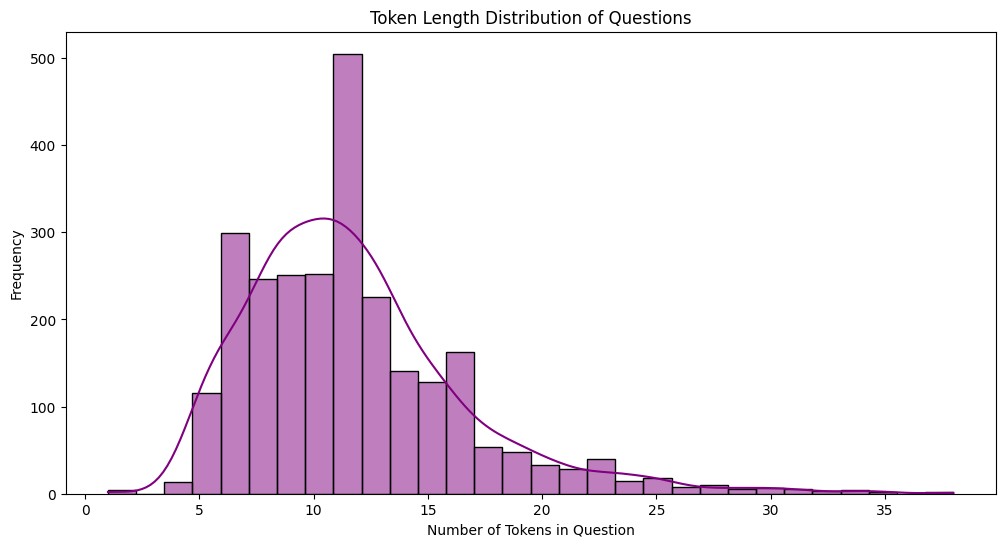

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


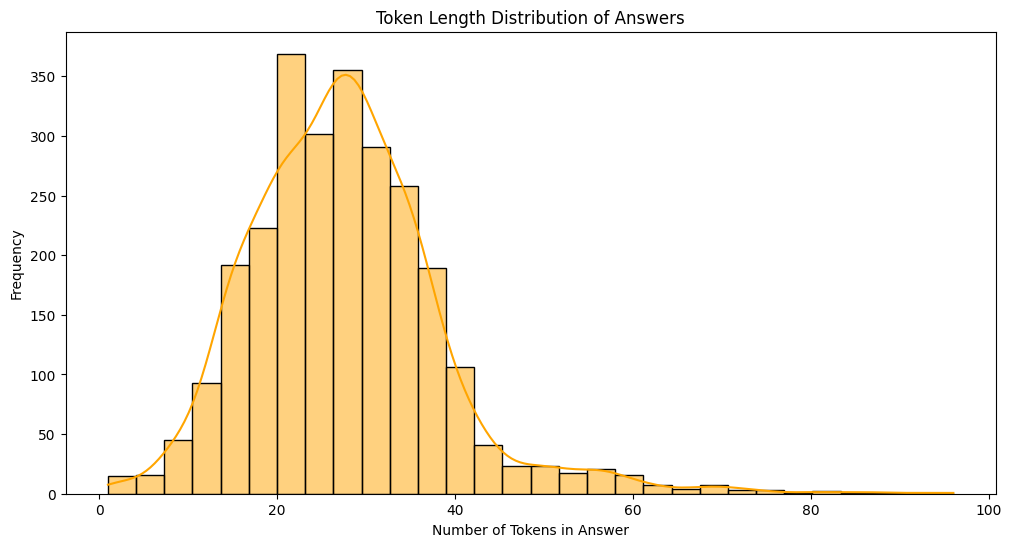

In [175]:
# Tokenize the questions and answers
train_df['question_token_length'] = train_df['question'].apply(lambda x: len(tokenizer.encode(x)))
train_df['answer_token_length'] = train_df['answer'].apply(lambda x: len(tokenizer.encode(x)))

# Plot the token length distribution for questions
plt.figure(figsize=(12, 6))
sns.histplot(train_df['question_token_length'], bins=30, kde=True, color='purple')
plt.title('Token Length Distribution of Questions')
plt.xlabel('Number of Tokens in Question')
plt.ylabel('Frequency')
plt.show()

# Plot the token length distribution for answers
plt.figure(figsize=(12, 6))
sns.histplot(train_df['answer_token_length'], bins=30, kde=True, color='orange')
plt.title('Token Length Distribution of Answers')
plt.xlabel('Number of Tokens in Answer')
plt.ylabel('Frequency')
plt.show()

In [127]:
# Load pre-trained tokenizer and model
model_name='gpt2'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [126]:
# Define the preprocess function for tokenization
def preprocess_function(examples):
    inputs = ['Q: ' + q + ' A: ' + a + tokenizer.eos_token for q, a in zip(examples['question'], examples['answer'])]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    
    # Copy input_ids to labels
    labels = model_inputs['input_ids'].copy()
    model_inputs['labels'] = labels
    
    return model_inputs

In [128]:
tokenized_train_dataset = datasets['train'].map(preprocess_function, batched=True)
tokenized_val_dataset = datasets['validation'].map(preprocess_function, batched=True)


# Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

Map:   0%|          | 0/2626 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [133]:
# Training arguments
batch_size = 4
num_epochs = 20

training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",    # output directory
    overwrite_output_dir=True,        # output directory
    num_train_epochs=num_epochs,      # number of epochs
    per_device_train_batch_size=4,    # batch size for training
    per_device_eval_batch_size=4,     # batch size for evaluation
    #eval_strategy="epoch",           # evaluate every epoch
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch",            # save checkpoints at end of epoch
    save_total_limit=1,
    evaluation_strategy="epoch",  
)
# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=None
)

# Train the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn

Epoch,Training Loss,Validation Loss
1,1.105400,2.395402
2,0.932600,2.485121
3,0.791200,2.617372
4,0.713800,2.715834
5,0.625500,2.794822
6,0.546300,2.722985
7,0.703400,2.748790
8,0.647300,2.780805
9,0.588400,2.812437
10,0.539000,2.856212


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=6580, training_loss=0.5640422609439375, metrics={'train_runtime': 2858.2805, 'train_samples_per_second': 18.375, 'train_steps_per_second': 2.302, 'total_flos': 6861528760320000.0, 'train_loss': 0.5640422609439375, 'epoch': 20.0})

In [134]:
trainer.save_model("./results/final_model")

In [135]:
!zip -r /kaggle/working/results/final_model.zip /kaggle/working/results/final_model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


updating: kaggle/working/results/final_model/ (stored 0%)
updating: kaggle/working/results/final_model/config.json (deflated 52%)
updating: kaggle/working/results/final_model/generation_config.json (deflated 24%)
updating: kaggle/working/results/final_model/training_args.bin (deflated 52%)
updating: kaggle/working/results/final_model/vocab.json (deflated 68%)
updating: kaggle/working/results/final_model/model.safetensors (deflated 7%)
updating: kaggle/working/results/final_model/tokenizer_config.json (deflated 55%)
updating: kaggle/working/results/final_model/special_tokens_map.json (deflated 74%)
updating: kaggle/working/results/final_model/merges.txt (deflated 53%)


In [136]:
from safetensors.torch import load_file as load_safetensors
model_name='gpt2'
model_path = "/kaggle/working/results/final_model"
state_dict = load_safetensors(f"{model_path}/model.safetensors")
model = GPT2LMHeadModel.from_pretrained(model_path, state_dict=state_dict)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [137]:
rouge = evaluate.load("rouge")

In [138]:
# Move model to the device
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [139]:
# Set pad_token to eos_token if it's not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [153]:
def generate_answer(question):
    input_ids = tokenizer.encode('Q: ' + question + ' A:', return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, device=device)
    output = model.generate(input_ids, attention_mask = attention_mask, max_new_tokens=60)
    gen_text = tokenizer.decode(output[0], skip_special_tokens=True)
    question, answer = gen_text.split(' A:', maxsplit=1)
    return answer
test_df['generated_answer'] = test_df['question'].apply(generate_answer)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [159]:
def ask_question(question):
    # Encode the input with the question
    inputs = tokenizer.encode('Q: ' + question + ' A:', return_tensors='pt').to(device)
    attention_mask = torch.ones(inputs.shape, device=device)
    
    # Generate the output
    outputs = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_new_tokens=100,
        num_return_sequences=1
    )
    
    # Decode the generated text
    gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Safely split the generated text into question and answer
    split_text = gen_text.split(' A:', maxsplit=1)
    
    # If splitting is successful, return both the question and answer
    if len(split_text) == 2:
        question, answer = split_text
    else:
        # In case there is no ' A:' separator, handle it gracefully
        question = gen_text
        answer = "[Could not generate a valid answer]"
    
    return question, answer


In [162]:
ask_question('What is the mean absolute error (MAE)?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: What is the mean absolute error (MAE)?',
 ' A: the mean absolute error is the average absolute difference between the observed and predicted values serving as a common metric for assessing the accuracy of model predictions focusing on the models performance on unseen data or observations that are not representative of the overall prediction accuracy commonly used for regression tasks in the midpoint of the range 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39')

In [163]:
print(ask_question('What is Q-Learning and how does it work?'))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: What is Q-Learning and how does it work?', ' A: A technique that updates the qvalues based on the training data it is used to update model parameters based on the error between predicted and actual values often used in reinforcement learning to minimize the loss function or adjust the policy for better performance on new data when the reward is too low to hit the optimal values based on the assumptions of the original model or training set A: answer qvalues are updated by averaging across multiple folds of the training data to get the optimal value for each fold often used in reinforcement')


In [164]:
ask_question('What is the difference between BERT and RoBERTa?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: What is the difference between BERT and RoBERTa?',
 ' A: bert is bidirectional and focuses on understanding context while robert bart is unidirectional and designed primarily for text generation tasks but can also be used for both classification and regression tasks A: bart is bidirectional and designed primarily for text generation while robert bart is unidirectional and designed for text generation only but can also be used for both classification and regression tasks depending on the task and model being used A: bart is bidirectional and designed primarily for text generation')

In [165]:
print(ask_question("What is the primary function of a Generative Adversarial Network (GAN)?"))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: What is the primary function of a Generative Adversarial Network (GAN)?', ' the primary function of a Generative adversarial network is to generate new samples by sampling from the input data through a series of convolutional and maxpooling layers enabling the network to learn global and local features the underlying structure of the data being sampled is used as input for the next step in the training process of the network the generator is trained using the generated samples as input for the next step in the training process of the model being trained the discriminator is trained using the output from the discrim')


In [168]:
ask_question("What does DNN stand for in the context of machine learning?")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: What does DNN stand for in the context of machine learning?',
 ' dnn stands for deep neural network a type of artificial neural network with multiple hidden layers that can learn complex representations and patterns from data like images and text dnns are a type of natural language processing unit that is widely used in various fields including machine learning and information retrieval systems for various types of natural language processing tasks including text classification language modeling and sentiment analysis using various nlp models and techniques like haar features extraction and fully connected networks for tasks like sentiment analysis and language modeling in various domains where machine')

In [169]:
ask_question('Is RNN using human assistance for backpropagation?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: Is RNN using human assistance for backpropagation?',
 ' no rnn does not require human assistance for backpropagation it is solely a design decisionmaking process based on algorithmic decisions and human feedback that define the policy and how the weights are adjusted for classification in the neural network layer A: answer backpropagation is a human controlled algorithm that is used for various tasks within the neural network including classification tasks including classification tasks and regression tasks rnns are designed and built by human trained algorithms and humans are trained to adapt and improve their algorithms based on')

In [170]:
ask_question('Why is slicing important and when is it used?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: Why is slicing important and when is it used?',
 ' slicing involves extracting specific subsets or portions of data from a larger dataset or array slicing is commonly used when working with a subset of data for analysis processing or visualization purposes such as in the imagenet dataset where slicing involves extracting specific subsets or portions it is frequently employed when working with a subset of larger datasets for analysis processing or visualization purposes such as in the web scraping dataset where slicing involves extracting specific portions or portions of data for analysis processing or visualization purposes it is employed when working with a subset of')

In [171]:
ask_question('Does the Squeeze function in Numpy remove all redundant dimensions by default?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Q: Does the Squeeze function in Numpy remove all redundant dimensions by default?',
 ' yes the squeeze function of numpy removes axes of length one from n array it takes the number of axes as input and returns a boolean array with axes of length two from n array this means that if the axis of length one is removed from the array it will be removed from the array in the next iteration of numpy this is because removing axes of length two from n array results in a removal of the squeeze function from array indexing which may lead to the creation of a smaller array this function is')

In [151]:
# Ensure the clean_answer function is defined
def clean_answer(answer):
    return answer.strip().lower()

# Generate predictions for the test set
predicted_answers = [generate_answer(q, max_new_tokens=50) for q in test_questions]

# Clean test answers
test_answers_cleaned = [clean_answer(a) for a in test_answers]

# Check if the lengths match
if len(predicted_answers) == len(test_answers_cleaned):
    # Compute ROUGE scores
    rouge_results = rouge.compute(predictions=predicted_answers, references=test_answers_cleaned)
    
    # Display ROUGE Scores
    print("ROUGE Scores:")
    for rouge_type, score in rouge_results.items():
        print(f"{rouge_type}: {score}")
else:
    print("Error: The number of predicted answers and test answers do not match.")

ROUGE Scores:
rouge1: 0.3040403393445019
rouge2: 0.12491566432588186
rougeL: 0.24937751520471774
rougeLsum: 0.24939773442384178
